In [1]:
import numpy as np
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

domains = ["amides", "sulfonamides", "ROH", "heterocycles", "alkyl amines", "anilines"]
DB_NAME='rxn_db.sql'

In [2]:
full_id = joblib.load('./array_joblibs/full_id_arrays_by_nuc.joblib')
full_desc = joblib.load('./array_joblibs/full_desc_arrays_by_nuc.joblib')
full_yield = joblib.load('./array_joblibs/full_y_arrays_by_nuc.joblib')

## Preparing arrays

In [3]:
def split_by_elec(id_array_dict, 
                  domain_list=domains):
    '''Splits reaction arrays into those that employ...
    1) electrophile 1
    2) electrophile 2 that is part of a small screen & follow-up exps
    3) all other rxns with electrophile 2.
    
    Parameters
    ----------
    id_array_dict : dict
        key : str (domain)
        val : id_array (np.2darray)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    inds_by_nuc : dict
        key : elec scheme (as shown above in 1,2,3)
        val : inds for each domain (list of three lists)
    '''
    inds_by_nuc = {}
    for i,domain in enumerate(domain_list) :
        id_array = id_array_dict[domain]
        list_of_inds = [[],[],[]]
        for i,row in enumerate(id_array):
            if row[1]==1:
                list_of_inds[0].append(i)
            else :
                if (row[2] in [1,2,8] and row[-1]==1) or\
                   (row[2] in [1,2,8] and row[3]==4 and row[-1]==2) or\
                   (row[2]==15 and row[3] in [1,2,3] and row[-1]==2):
                    list_of_inds[1].append(i)
                else : 
                    list_of_inds[2].append(i)
        inds_by_nuc.update({domain:list_of_inds})
    return inds_by_nuc


def prep_arrays(id_array_dict, desc_array_dict, y_array_dict,
                inds_by_nuc, domain_list=domains):
    ''' Divides full arrays into source and target arrays.
    
    Parameters
    ----------
    id_array_dict, desc_array_dict, y_array_dict : dict
        key : str (domain)
        val : id_array / desc_array (np.2darray)
               y_array ( np.1darray)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds by electrophile scheme)
    domain_list : list of str
        list of nucleophile domains to consider.
    
    Returns
    -------
    source_id_dict, source_desc_dict, source_y_dict,\
    target_id_dict, target_desc_dict, target_y_dict
    '''
    source_id_dict, source_desc_dict, source_y_dict = {}, {}, {}
    target_id_dict, target_desc_dict, target_y_dict = {}, {}, {}
    for i, domain in enumerate(domain_list):
        if i < 3:
            source_inds = inds_by_nuc[domain][0] + inds_by_nuc[domain][1]
            target_inds = inds_by_nuc[domain][2]
        else :
            source_inds = inds_by_nuc[domain][0]
            target_inds = inds_by_nuc[domain][1] + inds_by_nuc[domain][2]
        source_id_dict.update({domain:id_array_dict[domain][source_inds]})
        source_desc_dict.update({domain:desc_array_dict[domain][source_inds]})
        source_y_dict.update({domain:y_array_dict[domain][source_inds]})
        target_id_dict.update({domain:id_array_dict[domain][target_inds]})
        target_desc_dict.update({domain:desc_array_dict[domain][target_inds]})
        target_y_dict.update({domain:y_array_dict[domain][target_inds]})
    return source_id_dict, source_desc_dict, source_y_dict,\
           target_id_dict, target_desc_dict, target_y_dict
        

def plot_neg_portion(y_array_dict, inds_by_nuc, 
                     domain_list=domains, save=True):
    ''' Plots portion of negative reactions in each domain,
    by electrophile scheme.
    
    Parameters
    ----------
    y_array_dict : dict
        key : str (domain)
        val : np.1darray (binary yield labels)
    inds_by_nuc : dict
        key : str (domain)
        val : list of lists (inds for each scheme)
    domain_list : list of str
        domains considered.
    save : bool
        whether to save the resulting plot.
    
    Returns
    -------
    None
    '''
    neg_portion_by_domain = {
            "Domain":[],
            "Portion of Negatives":[],
            "Data":[]
    }
    for domain in domain_list:
        y_array = y_array_dict[domain]
        ind_list = inds_by_nuc[domain]
        elec1_neg_portion = 1-(sum(y_array[ind_list[0]])/len(ind_list[0]))
        common_elec2_neg_portion = 1-(sum(y_array[ind_list[1]])/len(ind_list[1]))
        uncommon_elec2_neg_portion = 1-(sum(y_array[ind_list[2]])/len(ind_list[2]))
        neg_portion_by_domain["Domain"].extend([domain]*3)
        neg_portion_by_domain["Portion of Negatives"].extend(
            [elec1_neg_portion,
             common_elec2_neg_portion,
             uncommon_elec2_neg_portion]
        )
        neg_portion_by_domain["Data"].extend(["Elec1", "Elec2 Train", "Elec2 Test"])
    
    fig, ax = plt.subplots()
    p=sns.barplot(data=neg_portion_by_domain, 
               x="Domain", y="Portion of Negatives", hue="Data",
               palette="viridis")
    ax.legend(bbox_to_anchor=(1.01,0.98))
    ax.set_yticks([x/5 for x in range(6)])
    ax.set_yticklabels([x/5 for x in range(6)])
    ax.set_ylabel("Portion of Negatives", fontsize=14)
    ax.set_xticks(p.get_xticks())
    ax.set_xticklabels(p.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
    ax.set_xlabel("Domain", fontsize=14)
    #ax.set_title("Label Distribution by Electrophile")
    for i in range(len(domain_list)-1):
        ax.axvline(i+0.5, alpha=0.7, linestyle='--', c='gray')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig("./figures/figureS2.pdf", dpi=300, format='pdf')

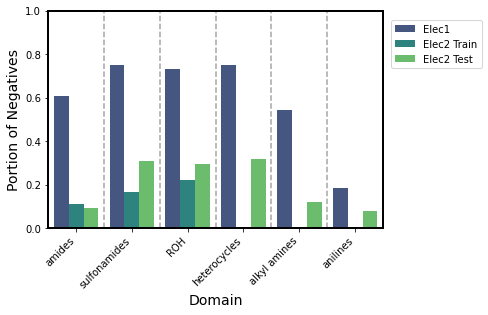

In [4]:
inds_by_nuc = split_by_elec(full_id)
plot_neg_portion(full_yield, inds_by_nuc)

In [5]:
source_id_dict, source_desc_dict, source_y_dict,\
target_id_dict, target_desc_dict, target_y_dict = prep_arrays(full_id, full_desc, full_yield,
                inds_by_nuc)

In [50]:
joblib.dump(source_id_dict, "./array_joblibs/source_id_dict.joblib")
joblib.dump(source_desc_dict, "./array_joblibs/source_desc_dict.joblib")
joblib.dump(source_y_dict, "./array_joblibs/source_y_dict.joblib")
joblib.dump(target_id_dict, "./array_joblibs/target_id_dict.joblib")
joblib.dump(target_desc_dict, "./array_joblibs/target_desc_dict.joblib")
joblib.dump(target_y_dict, "./array_joblibs/target_y_dict.joblib")

['./array_joblibs/target_y_dict.joblib']

In [5]:
source_id_dict = joblib.load("./array_joblibs/source_id_dict.joblib")
source_desc_dict = joblib.load("./array_joblibs/source_desc_dict.joblib")
source_y_dict = joblib.load("./array_joblibs/source_y_dict.joblib")
target_id_dict = joblib.load("./array_joblibs/target_id_dict.joblib")
target_desc_dict = joblib.load("./array_joblibs/target_desc_dict.joblib")
target_y_dict = joblib.load("./array_joblibs/target_y_dict.joblib")

## Performance by model complexity

In [6]:
def screen_depth_and_num_trees(source_X, source_y,
                               target_X_list, target_y_list,
                               depth_list, num_estimator_list,
                               max_fpr=1, cv_result_dict=None,
                               random_state=42):
    '''Screens the max_depth and n_estimators parameters. 
    
    Parameters
    ----------
    source_X, source_y : np.2d/1darrays
        descriptor and yield arrays of a single source domain.
    target_X_list, target_y_list : list of np.2d/1darrays
        descriptor and yield arrays of target domains.
    depth_list : list of ints & None
        max_depth values to consider.
    num_estimator_list : list of ints
        n_estimators values to consider.
    max_fpr : float [0,1]
        max false positive rate
    cv_result_dict : None or dict
        • None if first model is being considered.
        • dict if evaluating with more models.
    random_state : int
    
    Returns
    -------
    cv_result_dict : dict
        informations on performance on training, CV, target data.
    '''
    if cv_result_dict is None :
        cv_result_dict = {"Depth":[],
                          "Num Trees":[],
                          "Training Score":[],
                          "Training Sd":[],
                          "CV Score":[],
                          "CV Sd":[],
                          "Model":[],
                          "Transfer Score":[]}

    def update_dict(param_value_tuple, gridsearch, model,
                    transfer_score):
        cv_result_dict["Depth"].append(param_value_tuple[0])
        cv_result_dict["Num Trees"].append(param_value_tuple[1])
        cv_result_dict["Training Score"].append(
                    gridsearch.cv_results_["mean_train_score"][0]
        )
        cv_result_dict["Training Sd"].append(
                    gridsearch.cv_results_["std_train_score"][0]
        )
        cv_result_dict["CV Score"].append(
                    gridsearch.cv_results_["mean_test_score"][0]
        )
        cv_result_dict["CV Sd"].append(
                    gridsearch.cv_results_["std_test_score"][0]
        )
        cv_result_dict["Model"].append(model)
        cv_result_dict["Transfer Score"].append(transfer_score)
    
    def get_transfer_roc(gridsearch, target_X_list, target_y_list,
                         max_fpr):
        model = gridsearch.best_estimator_
        transfer_rocs = []
        for target_X, target_y in zip(target_X_list, target_y_list):
            proba = model.predict_proba(target_X)[:,1]
            roc = roc_auc_score(target_y, proba, max_fpr=max_fpr)
            transfer_rocs.append(roc)
        return model, transfer_rocs
    
    for i, depth in enumerate(depth_list):
        for j, num_trees in enumerate(num_estimator_list):
            if j==0 :
                rfc = RandomForestClassifier(random_state=random_state+i)
                param_grid = {"max_depth":[depth],
                              "n_estimators":[num_trees]}
            else :
                rfc = model.set_params(n_estimators=num_trees, 
                                       warm_start=True)
                param_grid = {"n_estimators":[num_trees]}
            if min([sum(source_y), len(source_y)-sum(source_y)])> 5:
                cv = 5
            elif min([sum(source_y), len(source_y)-sum(source_y)])>1:
                cv = int(min([sum(source_y), len(source_y)-sum(source_y)]))
            else :
                print("Not enough class members.")
                break
            grid_rfc = GridSearchCV(rfc, 
                                    param_grid=param_grid,
                                    scoring="roc_auc", cv=cv,
                                    return_train_score=True)
            grid_rfc.fit(source_X, source_y)
            model, transfer_rocs = get_transfer_roc(grid_rfc, target_X_list,
                                                    target_y_list, max_fpr)
            update_dict((depth, num_trees), 
                        grid_rfc, model, transfer_rocs)        
    return cv_result_dict


def prep_heatmap_friendly_arrays(cv_result_dict, 
                                 depth_list, num_tree_list,
                                 num_random_states_considered):
    '''Prepares an array that can plot a heatmap.
    
    Parameters
    ----------
    cv_result_dict : dict
        output of function above.
    depth_list, num_tree_list : lists of ints
        input of function above.
    num_random_states_considered : int
        number of models initiated differently.
        
    Returns
    -------
    train_score_array, CV_score_array: np.2darrays
        performances on IN-DOMAIN training and CV sets.
    het_score_array, alkyl_score_array, anil_score_array : np.2darrays
        performances of the source models on elec2 datasets in
        heterocycle, alkyl amines, aniline domains, respectively.
    '''
    train_score_array = np.zeros((len(depth_list), len(num_tree_list),
                                  num_random_states_considered))
    CV_score_array = np.zeros_like(train_score_array)
    het_score_array = np.zeros_like(train_score_array)
    alkyl_score_array = np.zeros_like(train_score_array)
    anil_score_array = np.zeros_like(train_score_array)
    
    tree_len = len(num_tree_list)
    depth_len = len(depth_list)
    for l in range(num_random_states_considered):
        for i, depth in enumerate(cv_result_dict["Depth"]):
            num_tree = cv_result_dict["Num Trees"][i]
            j = depth_list.index(depth)
            k = num_tree_list.index(num_tree)
            ind = tree_len*depth_len*l+depth_len*j+k
            train_score_array[j,k,l] = cv_result_dict["Training Score"][ind]
            CV_score_array[j,k,l] = cv_result_dict["CV Score"][ind]
            het_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][0]
            alkyl_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][1]
            anil_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][2]
        
    return train_score_array, CV_score_array,\
           het_score_array, alkyl_score_array, anil_score_array


def prep_heatmap(score_array, depth_list, num_tree_list, 
                 save, source, target):
    ''' Plots heatmaps of performances at different levels.
    
    Parameters
    ----------
    score_array : np.2darray
        output of function above.
    depth_list, num_tree_list : list of ints
        inputs used throughout.
        
    Returns
    -------
    None
    '''
    xlen = len(num_tree_list) -1
    ylen = len(depth_list) - 1
    fig, ax = plt.subplots(figsize=(xlen,ylen))
    avg_score = np.mean(score_array,axis=2)
    std_score = np.std(score_array, axis=2)
    annot_labels = [[0]*avg_score.shape[1] for x in range(avg_score.shape[0])]
    for i in range(avg_score.shape[0]):
        for j in range(avg_score.shape[1]):
            if round(std_score[i,j],2) >= 0.01 : 
                avg_std = f"{round(avg_score[i,j],2)}\n({round(std_score[i,j],2)})"
            else : 
                avg_std = f"{round(avg_score[i,j],2)}"
            annot_labels[i][j] = avg_std
    sns.heatmap(avg_score, cmap='viridis', 
                vmin=0.5, vmax=1, annot=annot_labels, fmt='')
    ax.set_yticklabels([str(x) for x in depth_list], 
                       verticalalignment="center")
    ax.set_ylabel("Maximum Depth of Trees", fontsize=14)
    ax.set_xticklabels(num_tree_list)
    ax.set_xlabel("Number of Trees", fontsize=14)
    if save:
        if target not in ["heterocycle", "alkyl amine", "aniline"]:
            fig.savefig(f"./figures/figureS3_{source}_{target}.pdf",
                        dpi=300, format="pdf")
        else : 
            fig.savefig(f"./figures/figureS3_{source}_to_{target}.pdf",
                        dpi=300, format="pdf")

In [18]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100,200,300,500]
CV_dict_list = []

for source in ["amides", "sulfonamides", "ROH"]:
    for i in range(10):
        if i==0 : cv_result_dict=None
        else : cv_result_dict = full_CV_dict
        full_CV_dict = screen_depth_and_num_trees(
                        source_desc_dict[source], 
                        source_y_dict[source],
                        [target_desc_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        [target_y_dict[x] for x in ["heterocycles", "alkyl amines", "anilines"]],
                        depth_list, num_tree_list, random_state=42+i,
                        cv_result_dict=cv_result_dict
                    )
    CV_dict_list.append(full_CV_dict)

In [20]:
joblib.dump(CV_dict_list, "./array_joblibs/CV_dict_list.joblib")

['./array_joblibs/CV_dict_list.joblib']

In [7]:
CV_dict_list = joblib.load("./array_joblibs/CV_dict_list.joblib")

In [9]:
depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100,200,300,500]

### Source: amide

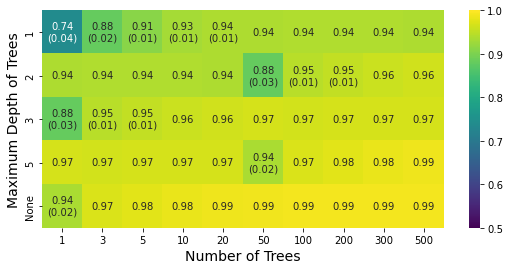

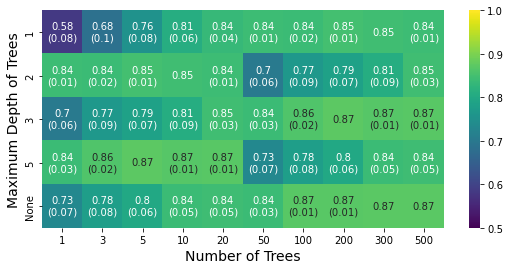

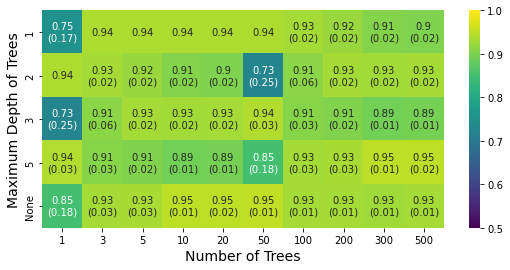

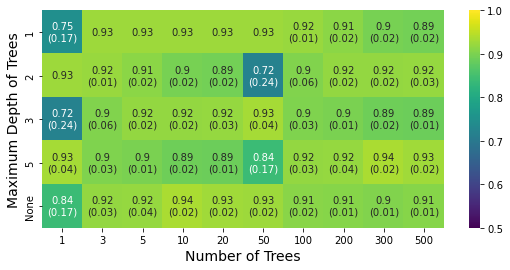

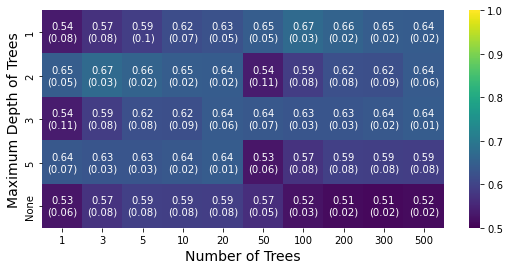

In [13]:
amide_train_score_array, amide_CV_score_array,\
amide_het_score_array, amide_alkyl_score_array, amide_anil_score_array = prep_heatmap_friendly_arrays(
                                CV_dict_list[0], depth_list, num_tree_list, 10
                        )
prep_heatmap(amide_train_score_array, depth_list, num_tree_list,
             False, "amides", "training")
prep_heatmap(amide_CV_score_array, depth_list, num_tree_list,
             False, "amides", "CV")
prep_heatmap(amide_alkyl_score_array, depth_list, num_tree_list,
             False, "amides", "alkyl amine")
prep_heatmap(amide_anil_score_array, depth_list, num_tree_list,
             False, "amides", "aniline")
prep_heatmap(amide_het_score_array, depth_list, num_tree_list,
             False, "amides", "heterocycle")

### Source: sulfonamide

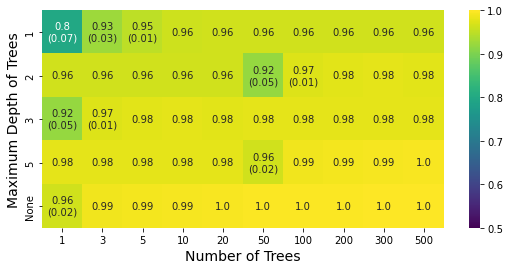

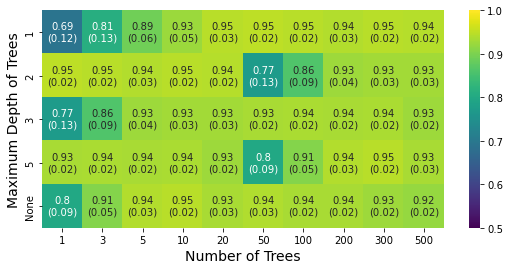

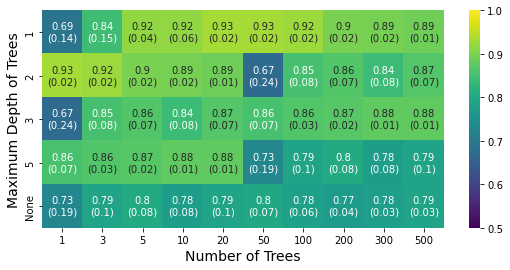

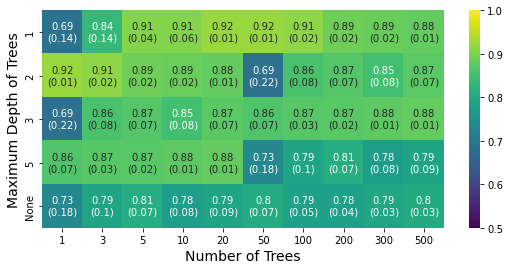

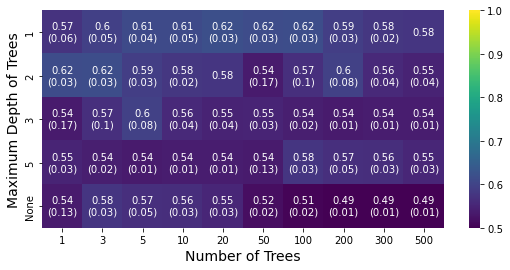

In [36]:
sulfon_train_score_array, sulfon_CV_score_array,\
sulfon_het_score_array, sulfon_alkyl_score_array, sulfon_anil_score_array = prep_heatmap_friendly_arrays(
                                CV_dict_list[1], depth_list, num_tree_list, 10
                        )
prep_heatmap(sulfon_train_score_array, depth_list, num_tree_list,
             False, "sulfonamide", "training")
prep_heatmap(sulfon_CV_score_array, depth_list, num_tree_list,
             False, "sulfonamide", "CV")
prep_heatmap(sulfon_alkyl_score_array, depth_list, num_tree_list,
             False, "sulfonamide", "alkyl amine")
prep_heatmap(sulfon_anil_score_array, depth_list, num_tree_list,
             False, "sulfonamide", "aniline")
prep_heatmap(sulfon_het_score_array, depth_list, num_tree_list,
             False, "sulfonamide", "heterocycle")

### Source: ROH

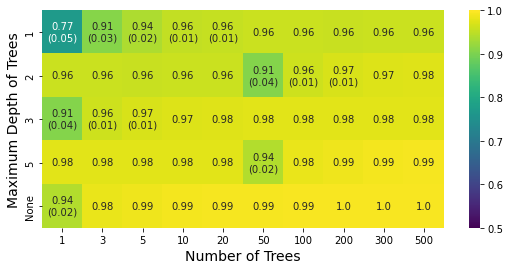

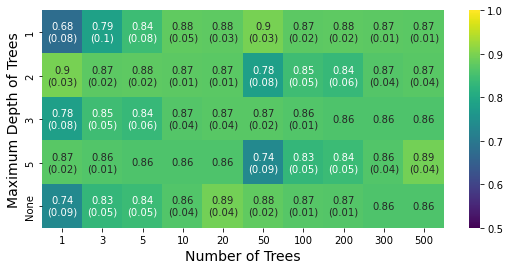

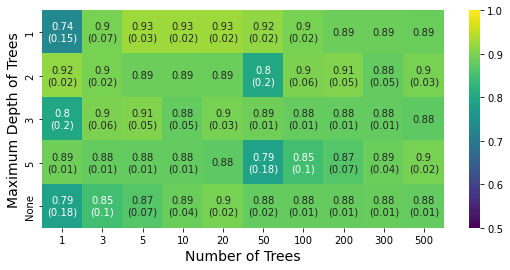

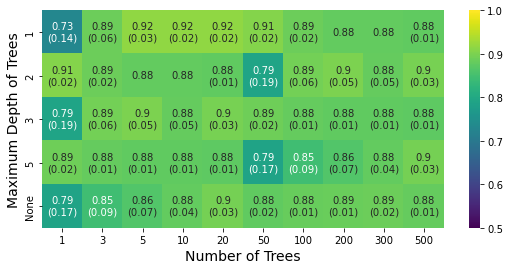

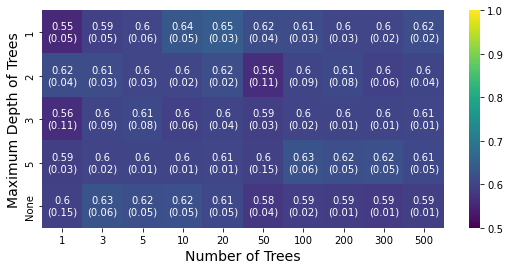

In [37]:
ROH_train_score_array, ROH_CV_score_array,\
ROH_het_score_array, ROH_alkyl_score_array, ROH_anil_score_array = prep_heatmap_friendly_arrays(
                                CV_dict_list[2], depth_list, num_tree_list, 10
                        )
prep_heatmap(ROH_train_score_array, depth_list, num_tree_list,
             False, "ROH", "training")
prep_heatmap(ROH_CV_score_array, depth_list, num_tree_list,
             False, "ROH", "CV")
prep_heatmap(ROH_alkyl_score_array, depth_list, num_tree_list,
             False, "ROH", "alkyl amine")
prep_heatmap(ROH_anil_score_array, depth_list, num_tree_list,
             False, "ROH", "aniline")
prep_heatmap(ROH_het_score_array, depth_list, num_tree_list,
             False, "ROH", "heterocycle")

### Lineplot

In [119]:
def prep_dict_for_lineplot(score_array_list, domain_list, target_list,
                           fix_depth, fixed_hyperparam_list,
                           hyperparam_val, screened_hyperparam_list,
                           num_models=10):
    ''' Prepares dictionary that seaborn can plot as lineplot.
    
    Parameters
    ----------
    score_array : list of np.2darrays
        scores collected.
    domain_list : list of str
        training, CV, target domains.
    fix_depth : bool
        • if True : get row values.
        • if False : get col values.
    hyperparam_list : list of ints
        {depth_list or num_tree_list}
    hyperparam_val : int
        an element within the hyperparam_list.
    num_models : int
        number of randomly initiated models considered.
        
    Returns
    -------
    dict_to_plot : dict
    '''
    dict_to_plot = {
            "ROC-AUC":[],
            "Domain":[],
            "Dataset":[],
            "Hyperparameter":[]
        }
    def update_dict(roc_auc, domain, target, hyperparam_list):
        dict_to_plot["ROC-AUC"].extend(roc_auc)
        dict_to_plot["Domain"].extend([domain]*len(roc_auc))
        dict_to_plot["Dataset"].extend([target]*len(roc_auc))
        dict_to_plot["Hyperparameter"].extend(hyperparam_list)

    ind_to_collect = fixed_hyperparam_list.index(hyperparam_val)
    for i, array in enumerate(score_array_list) : 
        for j in range(num_models):
            if fix_depth :
                roc_auc = list(array[ind_to_collect,:,j])
            else :
                roc_auc = list(array[:,ind_to_collect,j])
            update_dict(roc_auc, domain_list[i], 
                        target_list[i], screened_hyperparam_list)
    return dict_to_plot


def get_max_points(score_array_list, 
                   fixed_depth, fixed_hyperparam_ind, 
                   screened_hyperparam_list, num_models=10):
    ''' Computes coordinates of maximum ROC-AUC.
    
    Parameters
    ----------
    dict_to_plot : dict
        output of function above.
    target_list, screened_hyperparam_list : list
        inputs of function above.
    
    Returns
    -------
    [[x_coords], [y_coords]]
    '''
    
    x_coords = []
    y_coords = []
    for score_array in score_array_list : 
        avg_score_array = np.mean(score_array, axis=2)
        if fixed_depth : 
            scores_to_consider = avg_score_array[fixed_hyperparam_ind,:]
        else :
            scores_to_consider = avg_score_array[:,fixed_hyperparam_ind]
        max_ind = np.argmax(scores_to_consider)
        x_coords.append(screened_hyperparam_list[max_ind])
        max_score = scores_to_consider[max_ind]
        y_coords.append(max_score)
    return [x_coords, y_coords]
    

def plot_roc_by_domain(dict_to_plot, max_coord, sim_coord,
                       xlabel, xlog, filename=None):
    ''' Plots line-plot of ROC-AUC by evaluating domain.'''
    fig, ax = plt.subplots()
    ax.scatter(max_coord[0][:2], max_coord[1][:2], marker='s',
               color="None", edgecolor="red", s=110, linewidth=2)
    ax.scatter(max_coord[0][2:], max_coord[1][2:], marker='s',
               color="None", edgecolor="black", s=110, linewidth=2)
    ax.scatter(sim_coord[0], sim_coord[1], 
               color="None", edgecolor="black", s=110, 
               ls='--')
    
    sns.lineplot(x="Hyperparameter", y="ROC-AUC", data=dict_to_plot,
                 hue="Domain", style="Dataset", ci=None,
                 markers=True)
    
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("ROC-AUC", fontsize=14)
    ax.set_yticks([0.1*(x+5) for x in range(6)])
    ax.set_yticklabels([round(0.1*(x+5),1) for x in range(6)])
    plt.legend(bbox_to_anchor=(1.01,0.95))
    if xlog:
        ax.set_xscale('log')
    else :
        ax.set_xticks([1,2,3,5,10])
        ax.set_xticklabels([1,2,3,5,10])
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if filename is not None : 
        fig.savefig(f"./figures/figure4{filename}.pdf", format="pdf", dpi=300)

In [105]:
amide_depth_dict_to_plot = prep_dict_for_lineplot(
            [amide_train_score_array, amide_CV_score_array,
             amide_het_score_array, amide_anil_score_array],
            ["In-Domain", "In-Domain", "Transfer", "Transfer"],
            ["Training", "CrossValidation", "Heterocycle", "Aniline"],
            True, depth_list, 3, num_tree_list
)
amide_tree_dict_to_plot = prep_dict_for_lineplot(
            [amide_train_score_array, amide_CV_score_array,
             amide_het_score_array, amide_anil_score_array],
            ["In-Domain", "In-Domain", "Transfer", "Transfer"],
            ["Training", "CrossValidation", "Heterocycle", "Aniline"],
            False, num_tree_list, 20, [1,2,3,5,10]
)

In [106]:
depth_max_coords = get_max_points(
            [amide_train_score_array, amide_CV_score_array,
             amide_het_score_array, amide_anil_score_array], 
            True, 2, 
            num_tree_list
)

trees_max_coords = get_max_points(
            [amide_train_score_array, amide_CV_score_array,
             amide_het_score_array, amide_anil_score_array], 
            False, 4, 
            [1,2,3,5,10]
)

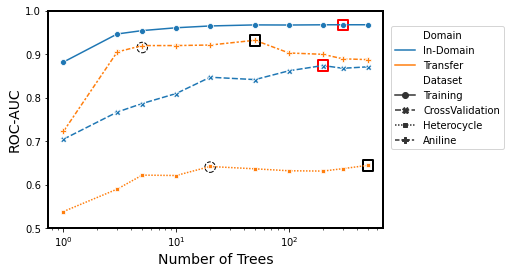

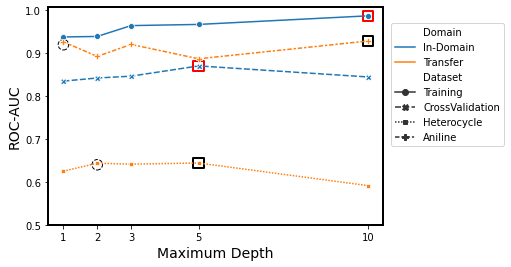

In [121]:
plot_roc_by_domain(amide_depth_dict_to_plot, depth_max_coords, 
                   [[5,20],[0.915,0.64]], "Number of Trees", True, "A")
plot_roc_by_domain(amide_tree_dict_to_plot, trees_max_coords, 
                   [[1,2],[0.92,0.64]], "Maximum Depth",  False, "B")